# APTOS 2019 Blindness Detection

New Idea Ref : https://www.kaggle.com/ratthachat/aptos-simple-preprocessing-decoloring-cropping

## Circle Crop

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import os
from pathlib import Path
from IPython.display import Image as display_image
from IPython.display import display
print(os.listdir("../input"))

import cv2
from PIL import Image
import imagesize
from scipy import ndimage

['test.csv', 'train.csv', 'sample_submission.csv', 'train_images', 'test_images', 'aptos2019-blindness-detection']


### data load

In [2]:
train_df = pd.read_csv("../input/train.csv")

### define function

In [3]:
def load_image(id):
    img_path = Path().absolute().parent / "input" / "train_images" / "{}.png".format(id)
    
    if img_path.exists():
        d_level = int(train_df.query("id_code == '{}'".format(id)).iloc[0, 1]) 
        diagnosis_dict = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}
    else:
        img_path = Path().absolute().parent / "input" / "test_images" / "{}.png".format(id)
        
    return cv2.imread(str(img_path), 1)

In [4]:
def edge_detection(img):
    dst = cv2.medianBlur(img, ksize=5)
    sub = cv2.addWeighted(dst, 4, cv2.GaussianBlur( dst , (7, 7) , 0) ,-1 ,80)
    _b, _g, sub = cv2.split(sub)
    _b, _g, dst = cv2.split(dst)
    dst = cv2.addWeighted(dst, 0.5, sub, 0.5, 0)    
    _, dst = cv2.threshold(dst, np.mean(dst)/2, 255, cv2.THRESH_BINARY)
    dst = cv2.Canny(dst, 0, 100)
    dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2RGB)
    
    _, dst = cv2.threshold(dst, 10, 255, cv2.THRESH_BINARY)
    return dst

In [5]:
def calc_center_circle(edge_img, loop=5000):
    def calc_center_pixcel(A, B, C, D):
        def calc_lineparams(ax, ay, bx, by):
            if (by - ay) == 0:
                by = by + 1
            slope = (ax - bx) / (by - ay)
            section = ((by**2 - ay**2) - (ax**2 - bx**2)) / (2 * (by - ay))
            return slope, section

        A_slope, A_section = calc_lineparams(A[0], A[1], B[0], B[1])
        B_slope, B_section = calc_lineparams(C[0], C[1], D[0], D[1])

        if abs(A_slope - B_slope) < 0.01:
            return None, None

        X = (B_section - A_section) / (A_slope - B_slope)
        Y = (A_slope * X + A_section + B_slope * X + B_section) / 2

        return int(X), int(Y)
    
    edge_list = np.where(edge_img[:, :, 2] == 255)
    edge_list = [(edge_list[1][i], edge_list[0][i]) for i in range(len(edge_list[0]))]
    X_cand, Y_cand = [], []
    for _ in range(loop):
        edge_sample = []
        edge_sample.extend(edge_list[i] for i in np.random.randint(0, int(len(edge_list)/2), 2))
        edge_sample.extend(edge_list[i] for i in np.random.randint(int(len(edge_list)/2), len(edge_list), 2))
        x, y = calc_center_pixcel(edge_sample[0], edge_sample[2], edge_sample[1], edge_sample[3])
        if x is not None:
            X_cand.append(x)
            Y_cand.append(y)
    X, Y = int(np.mean(X_cand)), int(np.mean(Y_cand))
    
    r_list = [np.sqrt((X-e[0])**2+(Y-e[1])**2) for e in edge_list]
    radius = int(np.median(r_list))
    return (X, Y), radius

In [6]:
def center_crop(img, center, radius):
    height, width, _ = img.shape
    mask = np.zeros((height, width), np.uint8)
    
    mask = cv2.circle(mask, center, radius, (255, 255, 255), thickness=-1)
    mask_img = cv2.bitwise_and(img, img, mask=mask)
    
    crop_img = np.zeros((radius*2, radius*2, 3), np.uint8)
    cl, cr, ct, cb = 0, radius*2, 0, radius*2
    il, ir, it, ib = 0, width, 0, height
    if center[1] - radius > 0:
        it = center[1] - radius
    else:
        ct = radius - center[1]
        
    if height - center[1] > radius:
        ib -= (height - center[1]) - radius
    else:
        cb -= radius - (height - center[1])
        
    if center[0] - radius > 0:
        il = center[0] - radius
    else:
        cl = radius - center[0]
    
    if width - center[0] > radius:
        ir -= (width - center[0]) - radius
    else:
        cr -= radius - (width - center[0])
    
    crop_img[ct:cb, cl:cr, :] = mask_img[it:ib, il:ir, :]
    return crop_img

In [7]:
# file_name = "00cb6555d108"
file_name = "005b95c28852"
# file_name = "01499815e469"
# file_name = "0167076e7089"
f_list = ["005b95c28852", "00cb6555d108", "01499815e469", "0167076e7089"]

In [8]:
class EdgeCrop(object):
    def __init__(self, center_search_loop=5000):
        self.loop = center_search_loop

    def _edge_detection(self, img):
        dst = cv2.medianBlur(img, ksize=5)
        sub = cv2.addWeighted(dst, 4, cv2.GaussianBlur( dst , (7, 7) , 0) ,-1 ,80)
        _b, _g, sub = cv2.split(sub)
        _b, _g, dst = cv2.split(dst)
        dst = cv2.addWeighted(dst, 0.5, sub, 0.5, 0)    
        _, dst = cv2.threshold(dst, np.mean(dst)/2, 255, cv2.THRESH_BINARY)
        dst = cv2.Canny(dst, 0, 100)
        dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2RGB)
        _, dst = cv2.threshold(dst, 10, 255, cv2.THRESH_BINARY)
        return dst
    
    def _calc_center_circle(self, edge_img, loop=5000):
        def calc_center_pixcel(A, B, C, D):
            def calc_lineparams(ax, ay, bx, by):
                if (by - ay) == 0:
                    by = by + 1
                slope = (ax - bx) / (by - ay)
                section = ((by**2 - ay**2) - (ax**2 - bx**2)) / (2 * (by - ay))
                return slope, section

            A_slope, A_section = calc_lineparams(A[0], A[1], B[0], B[1])
            B_slope, B_section = calc_lineparams(C[0], C[1], D[0], D[1])

            if abs(A_slope - B_slope) < 0.01:
                return None, None

            X = (B_section - A_section) / (A_slope - B_slope)
            Y = (A_slope * X + A_section + B_slope * X + B_section) / 2

            return int(X), int(Y)
        
        edge_list = np.where(edge_img[:, :, 2] == 255)
        edge_list = [(edge_list[1][i], edge_list[0][i]) for i in range(len(edge_list[0]))]
        X_cand, Y_cand = [], []
        for _ in range(loop):
            edge = []
            edge.extend(edge_list[i] for i in np.random.randint(0, int(len(edge_list)/2), 2))
            edge.extend(edge_list[i] for i in np.random.randint(int(len(edge_list)/2), len(edge_list), 2))
            x, y = calc_center_pixcel(edge[0], edge[2], edge[1], edge[3])
            if x is not None:
                X_cand.append(x)
                Y_cand.append(y)
        
        X, Y = int(np.mean(X_cand)), int(np.mean(Y_cand))
        r_list = [np.sqrt((X-e[0])**2+(Y-e[1])**2) for e in edge_list]
        radius = int(np.median(r_list))
        return (X, Y), radius
    
    def _center_crop(self, img, center, radius):
        height, width, _ = img.shape
        mask = np.zeros((height, width), np.uint8)
        
        mask = cv2.circle(mask, center, radius, (255, 255, 255), thickness=-1)
        mask_img = cv2.bitwise_and(img, img, mask=mask)
        
        crop_img = np.zeros((radius*2, radius*2, 3), np.uint8)
        cl, cr, ct, cb = 0, radius*2, 0, radius*2
        il, ir, it, ib = 0, width, 0, height
        if center[1] - radius > 0:
            it = center[1] - radius
        else:
            ct = radius - center[1]
        
        if height - center[1] > radius:
            ib -= (height - center[1]) - radius
        else:
            cb -= radius - (height - center[1])
        
        if center[0] - radius > 0:
            il = center[0] - radius
        else:
            cl = radius - center[0]
        
        if width - center[0] > radius:
            ir -= (width - center[0]) - radius
        else:
            cr -= radius - (width - center[0])
        
        crop_img[ct:cb, cl:cr, :] = mask_img[it:ib, il:ir, :]
        return crop_img
    
    def __call__(self, img):
        edge = self._edge_detection(img)
        center, radius = self._calc_center_circle(edge, loop=self.loop)
        img = self._center_crop(img, center=center, radius=radius)
        return img

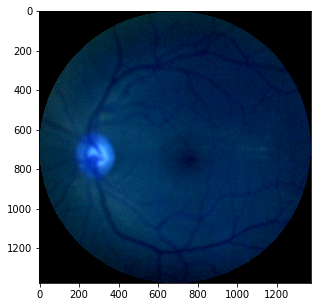

In [9]:
cropper = EdgeCrop()

for file_name in f_list[:1]:
    img = load_image(file_name)
    img = cropper(img)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)

In [10]:
img = load_image(file_name)

In [11]:
edge = edge_detection(img)

In [12]:
center, radius = calc_center_circle(edge)

In [13]:
crop_img = center_crop(img, center, radius)

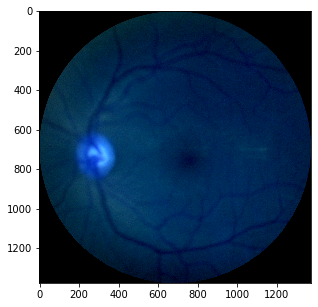

In [14]:
plt.figure(figsize=(5, 5))
plt.imshow(crop_img, cmap="gray")

## Debug

In [15]:
def center_crop_inv(img, center, radius):
    height, width, _ = img.shape
    mask = np.zeros((height, width), np.uint8)
    
    mask = cv2.circle(mask, center, radius, (255, 255, 255), thickness=-1)
    inv_img = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask))
    gray_img = cv2.cvtColor(inv_img, cv2.COLOR_BGR2GRAY)
    inv = gray_img.copy()
    inv[gray_img < 2] = 0 
    inv[gray_img >= 2] = 255
    return inv

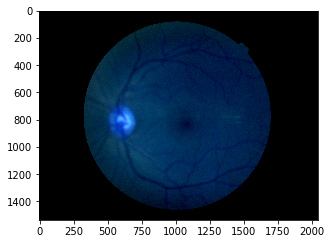

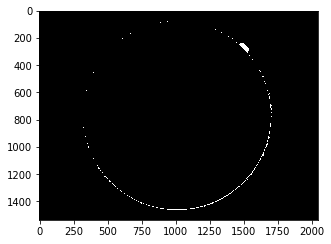

In [16]:
inv = center_crop_inv(img, center, radius)
plt.figure(figsize=(5, 5))
plt.imshow(img, "gray")
plt.figure(figsize=(5, 5))
plt.imshow(inv, "gray")

In [17]:
def debug_panel(img_id):
    img = load_image(file_name)
    edge = edge_detection(img)
    center, radius = calc_center_circle(edge)
    inv = center_crop_inv(img, center, radius)
    inv = cv2.resize(inv, (100, 100))
    return inv

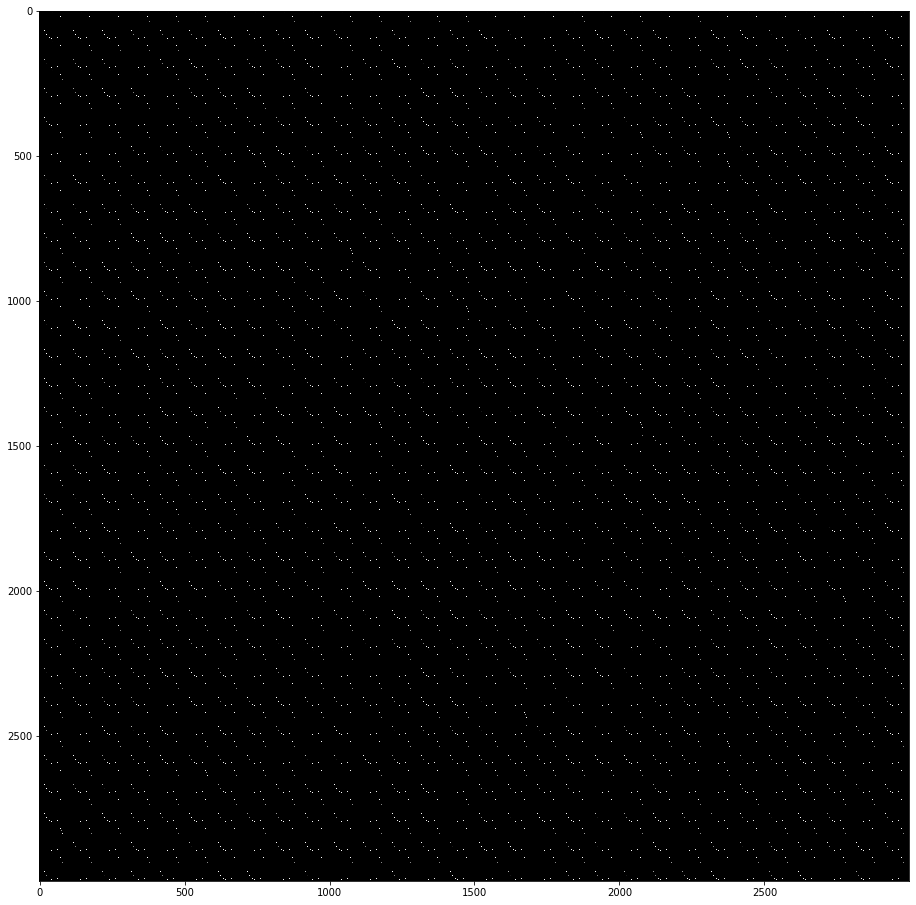

In [20]:
indice = train_df["id_code"].tolist()

a = None
panel = []
for i in range(30):
    temp = []
    for j in range(30):
        inv = debug_panel(indice[i*10+j])
        temp.append(inv)
    panel.append(np.hstack(temp))
panel = np.vstack(panel)

plt.figure(figsize=(16, 16))
plt.imshow(panel, cmap="gray")    

In [18]:
indice[84]

'07083738b75e'